# Garnet Lattice-Gas Monte Carlo Simulation Data Analysis

This notebook contains the data analysis for a series of lattice-gas Monte Carlo simulations performed for a garnet-structure lattice.  
The simulations have been performed using the [`lattice_mc`](https://github.com/bjmorgan/lattice_mc) code \[1\].  

Simulations were performed for an ideal $2\times2\times2$ garnet lattice, containing 384 octahedral sites and 192 tetrahedral sites. The lattice site coordinates were generated from the cubic high-temperature Li<sub>7</sub>La<sub>3</sub>Zr<sub>2</sub>O<sub>12</sub> (LLZO) structure ([ICSD #422259]()) \[3\]. Octahedral and tetrahderal lattice site coordinates were defined using the centres of the respective polyhedra defined by the oxide sub-lattice. This construction considers each octahedron as a single $48g$ site. The network of diffusion pathways consists of connections between all nearest-neighbour tetrahedron–octahedron pairs. 

For each simulation, $n_\mathrm{Li}$ mobile particles are initially randomly distributed across the lattice sites. Equilibration consists of 1,000 simulation steps, followed by 10,000 step production steps. 

The simulation methods are described in [Lattice-Geometry Effects in Garnet Solid Electrolytes: A Lattice-Gas Monte Carlo Simulation Study]() \[2\].

## References

1. B. J. Morgan, *`lattice_mc`: A Python Lattice-Gas Monte Carlo Module*, [J. Open Source Software, **2**, 00247 (2017)](https://doi.org/10.21105/joss.00247)
2. B. J. Morgan, *Lattice-Geometry Effects in Garnet Solid Electrolytes: A Lattice-Gas Monte Carlo Simulation Study*, [R. Soc. Open Sci., **4**, 170824 (2017)](https://doi.org/10.1098/rsos.170824). 
3. J. Awaka, A. Takashima, K. Kataoka, N. Kijima, Y. Idemoto, J. Akimoto, *Crystal Structure of Fast Lithium-ion-conducting Cubic Li<sub>7</sub>La<sub>3</sub>Zr<sub>2</sub>O<sub>12</sub>*, [Chem. Lett. **40**, 60 (2011)](https://doi.org/10.1246/cl.2011.60).

In [1]:
import sys
import numpy as np
import pandas as pd
import scipy.ndimage
from scipy import interpolate
from scipy import stats
import version_information

In [2]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format='retina'

import figure_formatting
from figure_formatting import fontsize

The simulation data are recorded in `../data/garnet_data.csv`.  

Each entry contains the following information:

| label    | data |
|----------|------|
| `n_Li`   | Number of mobile particles on the lattice (representing lithium ions).  |
| `E_nn`   | Nearest-neighbour repulsion energy (in units of $kT$). |
| `E_site` | Relative energy to occupy an octahedral versus tetrahedral site. |
| `f`      | Single-particle correlation factor. |
| `f_I`    | Collective correlation factor. |
| `D_t`    | Tracer diffusion coefficient. |
| `D_coll` | Collective diffusion coefficient. |
| `n_oct`  | Average number of particles occupying octahedral sites. |
| `n_tet`  | Average number of particles occupying tetrahedral aites. |

In [3]:
filename = '../data/garnet_data.csv'
index = np.array( [ 'n_Li', 'E_nn', 'E_site', 'f', 'f_I', 'D_t', 'D_coll', 'n_oct', 'n_tet' ] )
data = pd.read_csv( filename, delim_whitespace = True, names = index, header = None, comment = '#' )
data.head()

,n_Li,E_nn,E_site,f,f_I,D_t,D_coll,n_oct,n_tet
0,1,0.0,0.0,1.010,1.010,6.352000e-07,6.352000e-07,0.67,0.33
1,32,0.0,0.0,0.948,0.999,5.643000e-07,5.947000e-07,21.33,10.67
2,64,0.0,0.0,0.902,0.995,5.053000e-07,5.577000e-07,42.67,21.33
3,96,0.0,0.0,0.856,1.005,4.495000e-07,5.281000e-07,64.01,31.99
4,128,0.0,0.0,0.808,0.999,3.965000e-07,4.898000e-07,85.34,42.66


Rescale the diffusion coefficients from $10^{-10}$ bohr$^2$ s$^{-1}$ to m$^2$ s$^{-1}$.

In [4]:
data.D_t *= 0.52918**2
data.D_coll *= 0.52918**2

Calculate some other data:

| column | data |
|--------|------|
| `H_R` | Haven ratio. |
| `site_ratio` | Ratio of octahedral to tetrahedral occupied sites. |
| `sigma_eff` | Normalised ionic conductivity. |

In [5]:
data[ 'H_R' ] = data[ 'f' ] / data[ 'f_I' ]
data[ 'site_ratio' ] = data[ 'n_oct' ] / data[ 'n_tet' ]
data[ 'sigma_eff' ] = data[ 'D_coll' ] * data[ 'n_Li' ]

Rescale the number of mobile particles (lithium ions) to give the stoichiometry $x$ per formula unit in A<sub>$x$</sub>B<sub>3</sub>C<sub>2</sub>O<sub>12</sub>.

In [6]:
data.n_Li /= 64.0
data.n_oct /= 64.0
data.n_tet /= 64.0

In [7]:
data.head()

,n_Li,E_nn,E_site,f,f_I,D_t,D_coll,n_oct,n_tet,H_R,site_ratio,sigma_eff
0,0.015625,0.0,0.0,1.010,1.010,1.778760e-07,1.778760e-07,0.010469,0.005156,1.000000,2.030303,1.778760e-07
1,0.500000,0.0,0.0,0.948,0.999,1.580218e-07,1.665347e-07,0.333281,0.166719,0.948949,1.999063,5.329111e-06
2,1.000000,0.0,0.0,0.902,0.995,1.414999e-07,1.561736e-07,0.666719,0.333281,0.906533,2.000469,9.995107e-06
3,1.500000,0.0,0.0,0.856,1.005,1.258741e-07,1.478846e-07,1.000156,0.499844,0.851741,2.000938,1.419692e-05
4,2.000000,0.0,0.0,0.808,0.999,1.110325e-07,1.371594e-07,1.333438,0.666562,0.808809,2.000469,1.755641e-05


Define plotting functions with some defaults.

In [8]:
def my_plot( subplot, x, y, marker='o-', linewidth=1.5, **kwargs ):
    subplot.plot( x, y, marker, markeredgewidth=0.0, clip_on=False, linewidth=linewidth, **kwargs )
    subplot.set_xticks( range(10) )
    
def setup_axes( ax, ylim, title='' ):
    ax.set_xlabel(r'$x_\mathrm{Li}$')
    ax.set_xlim([0,9.0])
    ax.set_ylim(ylim)
    ax.set_title(title, fontsize=fontsize, loc='left')

## Non-interacting particles
Construct a four-panel figure for the non-interacting system data, plotting:  
(a) the single-particle correlation factor, $f$, and collective correlation factor, $f_\mathrm{I}$,  
(b) the average number of occupied octahedral and tetrahedral sites, per formula unit, $x_\mathrm{oct}$ and $x_\mathrm{tet}$,  
(c) the tracer diffusion coefficient, $D^*$, and collective &ldquo;jump&rdquo; diffusion coefficient, $D_\mathrm{J}$, and  
(d) the reduced (scaled) ionic conductivity, $\sigma^\prime$. 

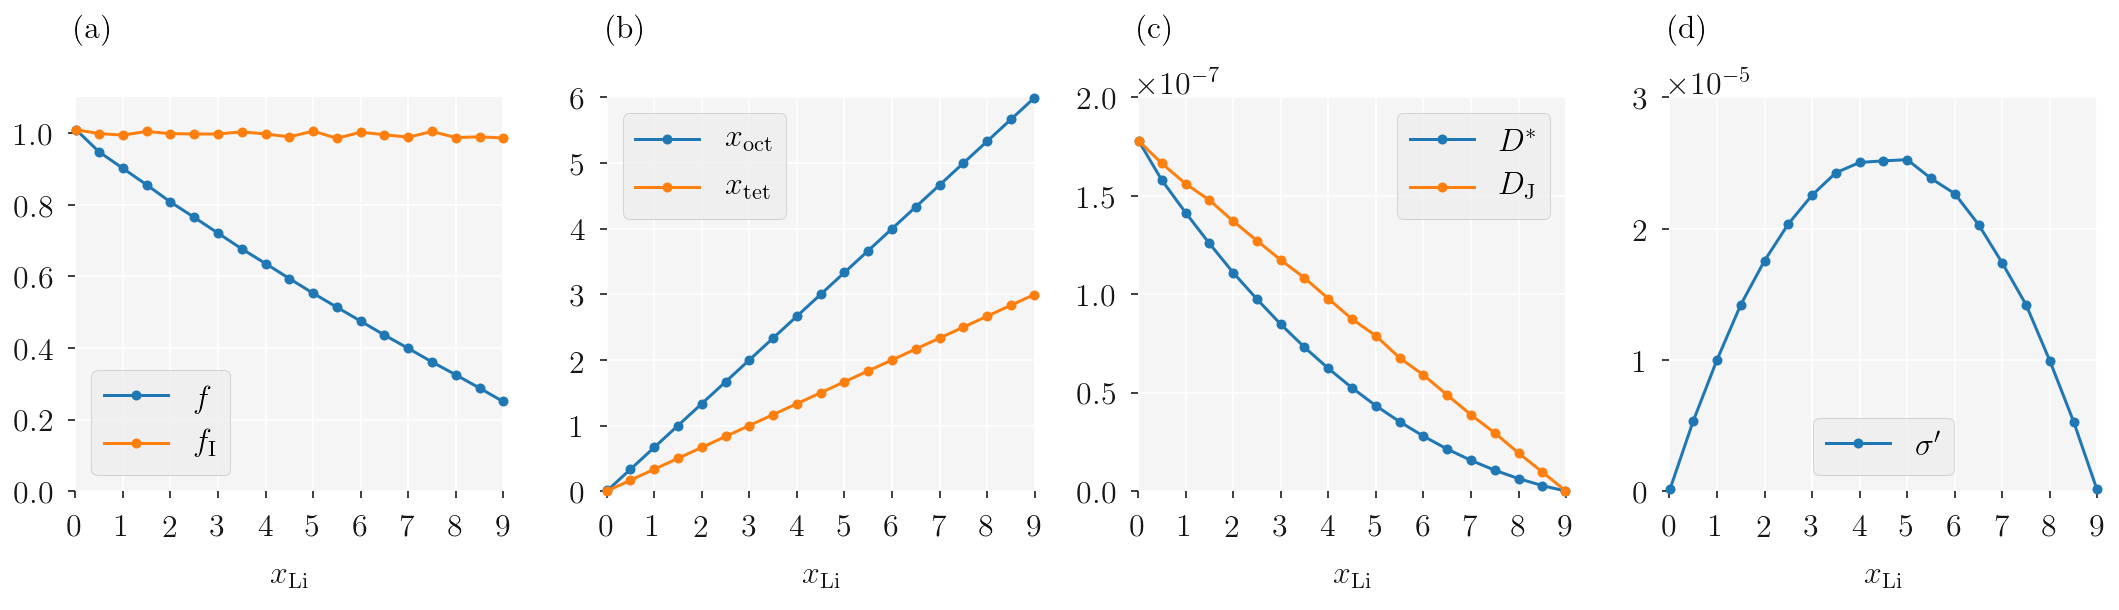

In [9]:
matplotlib.rcParams.update({'font.size': fontsize})

# select data for non-interacting systems.
df = data.loc[ ( data.E_nn == 0.0 ) & ( data.E_site == 0.0 ) ]

# set up the subplots
fig, axs = plt.subplots(1,4, figsize=(15, 4.5))
correlation_plot = axs[0]
occupation_plot = axs[1]
diffusion_plot = axs[2]
conductivity_plot = axs[3]
for ax in [ correlation_plot, occupation_plot, diffusion_plot, conductivity_plot ]:
    for s in [ 'top', 'bottom', 'left', 'right' ]:
        ax.spines[s].set_visible(False)
    ax.tick_params(labelsize=fontsize)

# Plot single particle correlation and collective correlation factors.
ax = correlation_plot
my_plot( ax, df.n_Li, df.f, label=r'$f$' )
my_plot( ax, df.n_Li, df.f_I, label=r'$f_\mathrm{I}$' )
setup_axes( ax, [0.0, 1.1], title='(a)' )
ax.legend()

# Plot average occupation of octahedral and tetrahedral sites.
ax = occupation_plot
my_plot( ax, df.n_Li, df.n_oct, label=r'$x_\mathrm{oct}$' )
my_plot( ax, df.n_Li, df.n_tet, label=r'$x_\mathrm{tet}$' )
setup_axes( ax, [0.0, 6.0], title='(b)' )
ax.legend()

# Plot the collective and tracer diffusion coefficients.
ax = diffusion_plot
my_plot( ax, df.n_Li, df.D_t,    label=r'$D^*$' )
my_plot( ax, df.n_Li, df.D_coll, label=r'$D_\mathrm{J}$' )
setup_axes( ax, [0, 2e-7], title='(c)' )
ax.legend()

# Plot the reduced ionic conductivity.
ax = conductivity_plot
my_plot( ax, df.n_Li, df.sigma_eff, label=r'$\sigma^\prime$' )
setup_axes( ax, [0.0, 3e-5], title='(d)' )
ax.legend(loc='lower center')
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0) )

plt.tight_layout()

# Save as PDF.
fig.savefig(fname='../figures/non-interacting_data.pdf')

(a) single particle correlation factor, $f$, and collective correlation factor, $f_\mathrm{I}$.  
(b) average occupations per formula unit for octahedral sites, $x_\mathrm{oct}$, and tetrahedral sites $x_\mathrm{tet}$.  
(c) tracer diffusion coefficient, $D^*$, and collective &ldquo;jump&rdquo; diffusion coefficient, $D_\mathrm{J}$.  
(d) reduced ionic conductivity, $\sigma^\prime$.

In [10]:
# Check R^2 for a straight line fit to the single particle correlation factor:
stats.linregress( df.n_Li/9, df.f ).rvalue**2

0.9973517078381422

## Interacting Particles

### Nearest-neighbour interactions

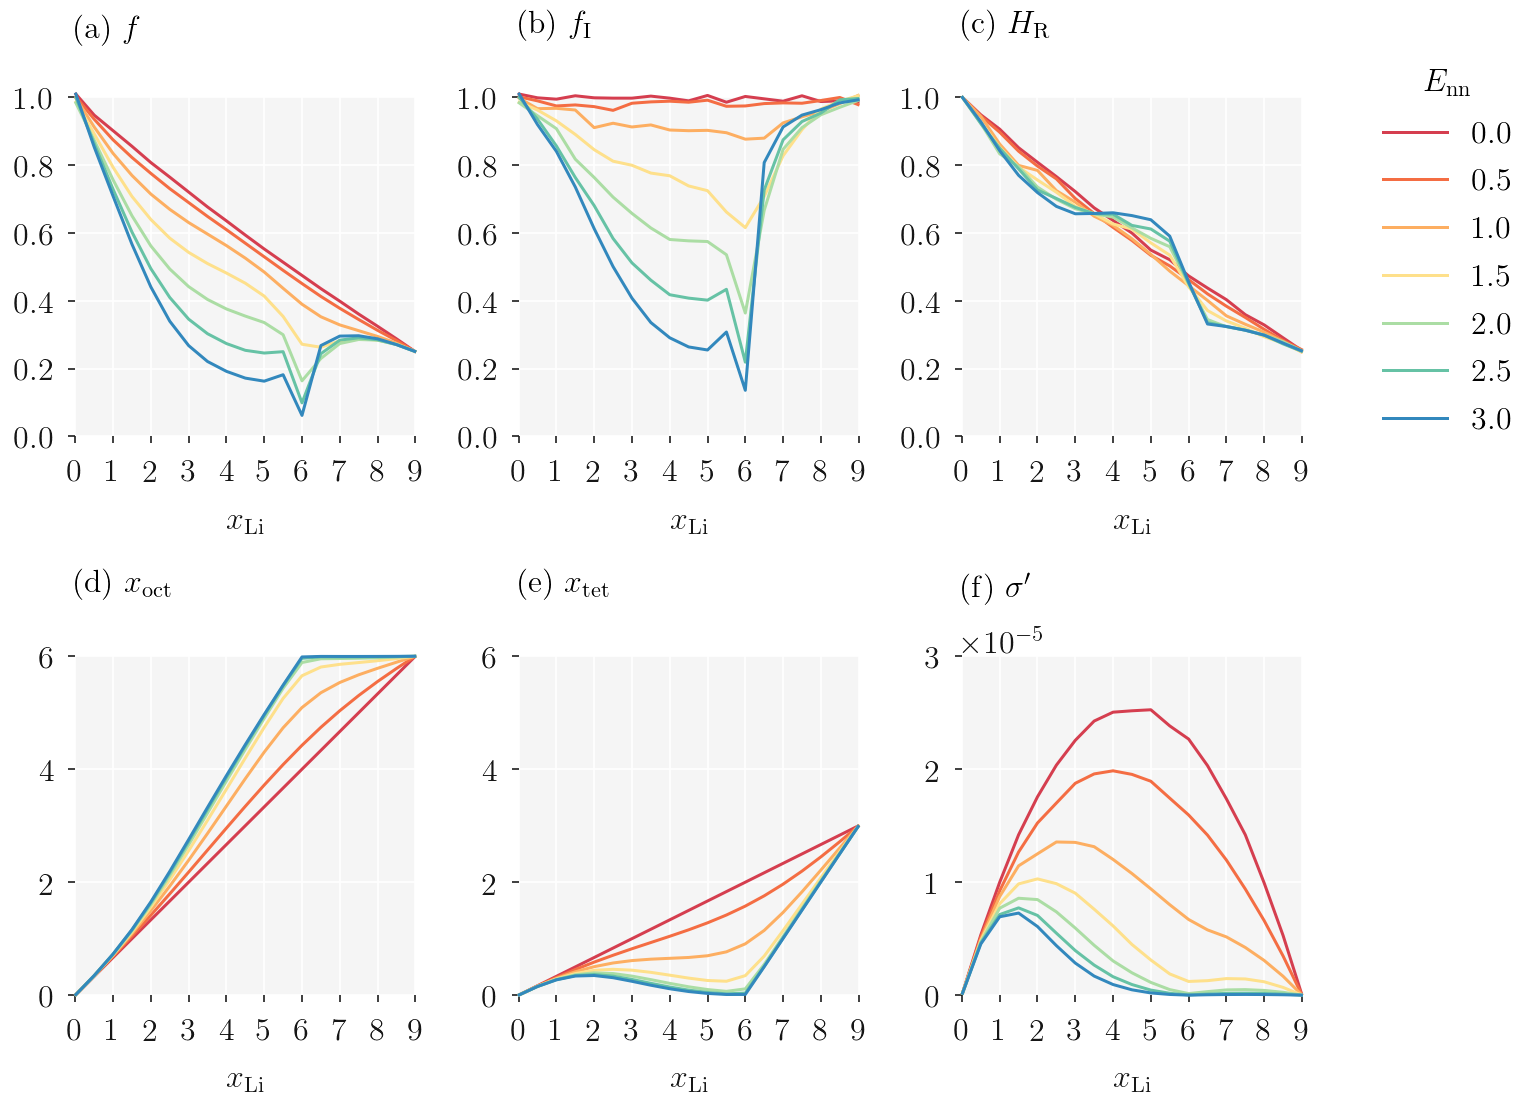

In [11]:
matplotlib.rcParams.update({'font.size': fontsize})
colors = [ '#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#abdda4', '#66c2a5', '#3288bd' ]

def variable_plot( ax, y, y_range, title ):
    ax.tick_params(labelsize=fontsize)
    for s in [ 'top', 'bottom', 'left', 'right' ]:
        ax.spines[s].set_visible(False)
    setup_axes( ax, y_range, title=title )
    for E_nn, c in zip( nn_energies, colors):
        df = data.loc[ (data.E_site == 0.0) & (data.E_nn == E_nn) ]
        my_plot( ax, df.n_Li, df[y], label=r'{}'.format(E_nn), marker='-', color=c )
    
nn_energies = [ 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0 ] 

# set up the subplots
fig, axs = plt.subplots(2,3, figsize=(11, 8))

# single-particle correlation
variable_plot( axs[0,0], 'f', [0,1],  title=r'(a) $f$' )
variable_plot( axs[0,1], 'f_I', [0,1],  title=r'(b) $f_\mathrm{I}$' )
variable_plot( axs[0,2], 'H_R', [0,1],  title=r'(c) $H_\mathrm{R}$' )
variable_plot( axs[1,0], 'n_oct', [0,6],  title=r'(d) $x_\mathrm{oct}$' )
variable_plot( axs[1,1], 'n_tet', [0,6],  title=r'(e) $x_\mathrm{tet}$' )
variable_plot( axs[1,2], 'sigma_eff', [0,3e-5], title=r'(f) $\sigma^\prime$' )
    
# place legend next to the top right subplot  
l = axs[0,2].legend(bbox_to_anchor=(1.2, -0.04), loc='lower left', borderaxespad=0., 
                    title=r'$E_\mathrm{nn}$', edgecolor='#FFFFFF', facecolor='#FFFFFF')
    
fig.tight_layout()

# Save as PDF.
fig.savefig(fname='../figures/nearest_neighbour_data.pdf')

### on-site energies

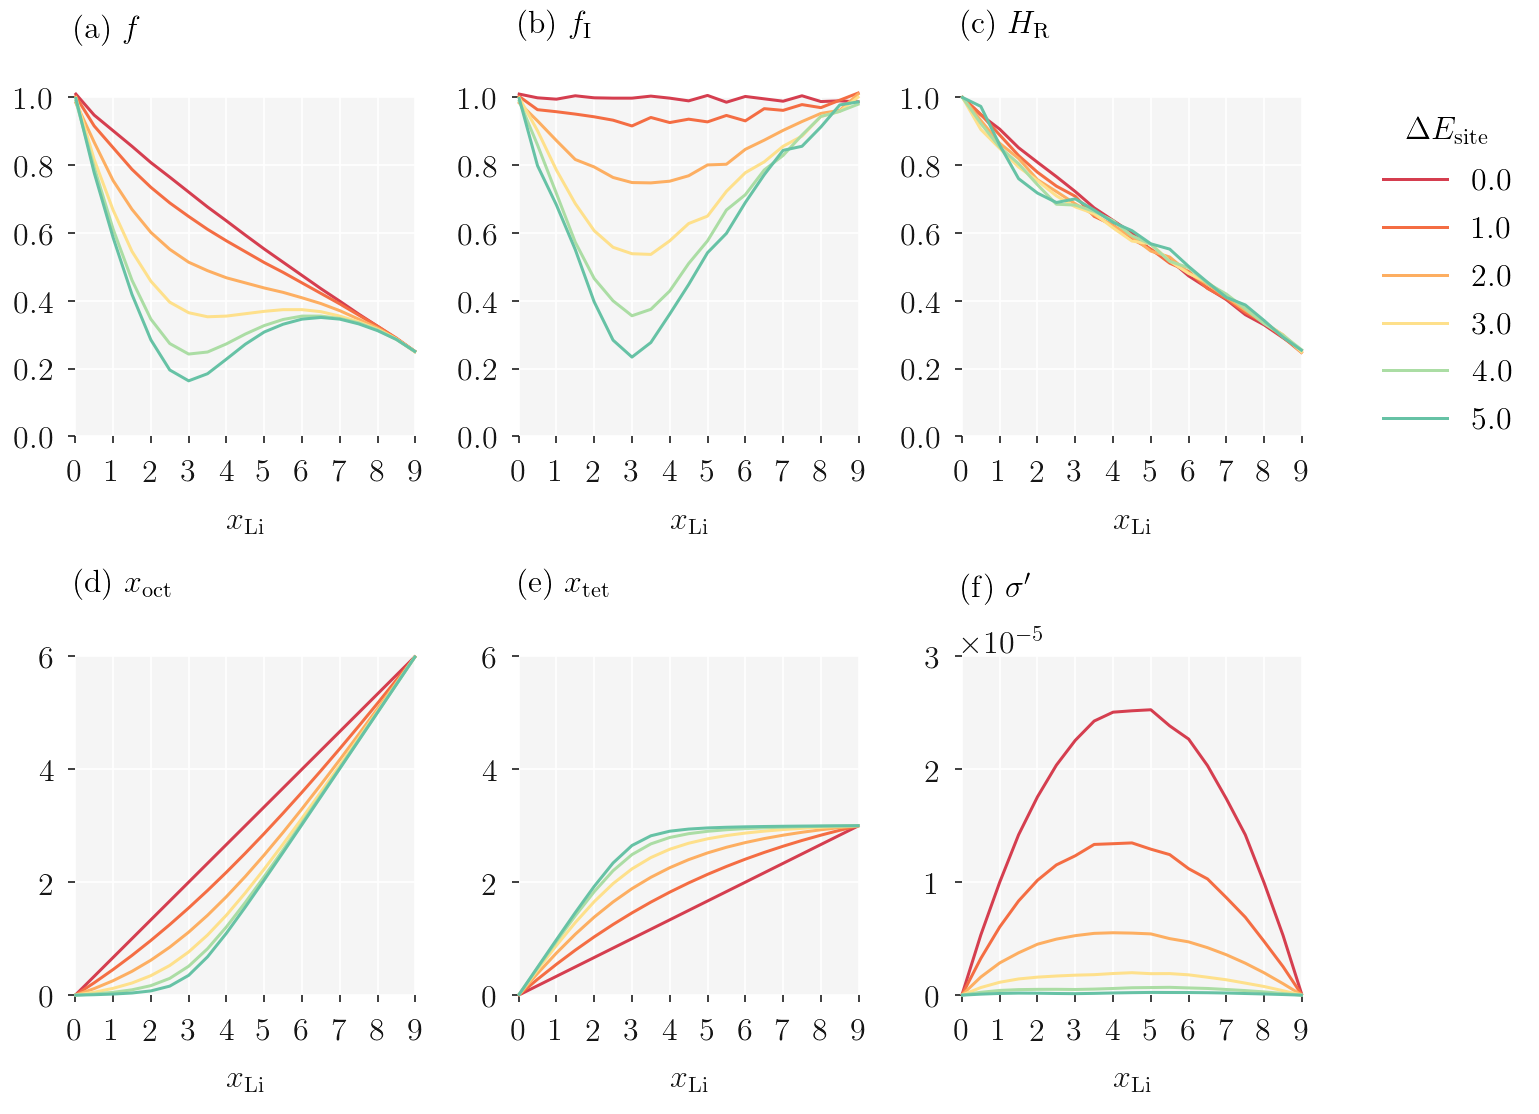

In [12]:
matplotlib.rcParams.update({'font.size': fontsize})
site_energies = [ 0.0, 1.0, 2.0, 3.0, 4.0, 5.0 ]

colors = [ '#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#abdda4', '#66c2a5', '#3288bd' ]

def variable_plot( ax, y, y_range, title ):
    ax.tick_params(labelsize=fontsize)
    for s in [ 'top', 'bottom', 'left', 'right' ]:
        ax.spines[s].set_visible(False)
    setup_axes( ax, y_range, title=title )
    for E_site, c in zip( site_energies, colors):
        df = data.loc[ (data.E_site == E_site) & (data.E_nn == 0.0) ]
        my_plot( ax, df.n_Li, df[y], label=r'{}'.format(E_site), marker='-', color=c )

# set up the subplots
fig, axs = plt.subplots(2,3, figsize=(11, 8))

# single-particle correlation
variable_plot( axs[0,0], 'f', [0,1],  title=r'(a) $f$' )
variable_plot( axs[0,1], 'f_I', [0,1],  title=r'(b) $f_\mathrm{I}$' )
variable_plot( axs[0,2], 'H_R', [0,1],  title=r'(c) $H_\mathrm{R}$' )
variable_plot( axs[1,0], 'n_oct', [0,6],  title=r'(d) $x_\mathrm{oct}$' )
variable_plot( axs[1,1], 'n_tet', [0,6],  title=r'(e) $x_\mathrm{tet}$' )
variable_plot( axs[1,2], 'sigma_eff', [0,3e-5], title=r'(f) $\sigma^\prime$' )
    
# place legend next to the top right subplot  
l = axs[0,2].legend(bbox_to_anchor=(1.2, -0.04), loc='lower left', borderaxespad=0., 
                    title=r'$\Delta E_\mathrm{site}$', edgecolor='#FFFFFF', facecolor='#FFFFFF')
    
fig.tight_layout()

# Save as PDF.
fig.savefig(fname='../figures/site_energies_data.pdf')

## Combined nearest-neighbour & site interactions

First, focussing on $E_\mathrm{nn}=\Delta E_\mathrm{site}$.

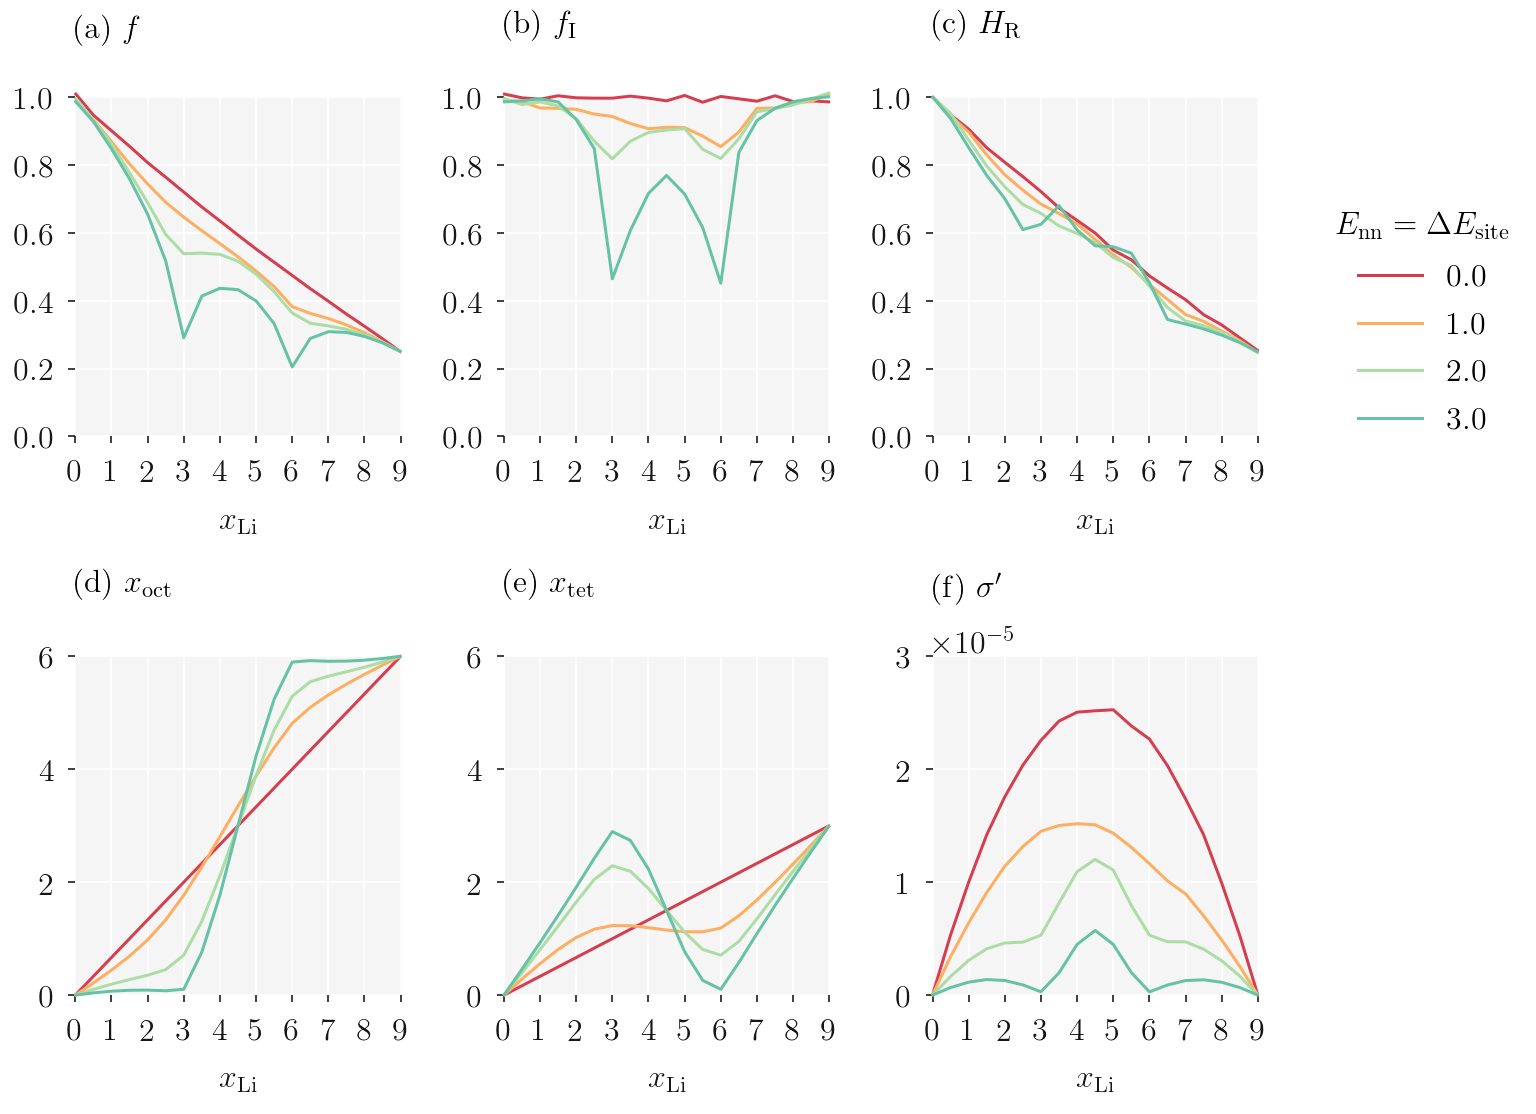

In [13]:
matplotlib.rcParams.update({'font.size': fontsize})
interaction_energies = [ 0.0, 1.0, 2.0, 3.0 ]

colors = [ '#d53e4f', '#fdae61', '#abdda4', '#66c2a5' ]

def variable_plot( ax, y, y_range, title ):
    ax.tick_params(labelsize=fontsize)
    for s in [ 'top', 'bottom', 'left', 'right' ]:
        ax.spines[s].set_visible(False)
    setup_axes( ax, y_range, title=title )
    for e, c in zip( interaction_energies, colors):
        df = data.loc[ (data.E_site == e) & (data.E_nn == e) ]
        my_plot( ax, df.n_Li, df[y], label=r'{}'.format(e), marker='-', color=c )

# set up the subplots
fig, axs = plt.subplots(2,3, figsize=(11, 8))

# single-particle correlation
variable_plot( axs[0,0], 'f', [0,1],  title=r'(a) $f$' )
variable_plot( axs[0,1], 'f_I', [0,1],  title=r'(b) $f_\mathrm{I}$' )
variable_plot( axs[0,2], 'H_R', [0,1],  title=r'(c) $H_\mathrm{R}$' )
variable_plot( axs[1,0], 'n_oct', [0,6],  title=r'(d) $x_\mathrm{oct}$' )
variable_plot( axs[1,1], 'n_tet', [0,6],  title=r'(e) $x_\mathrm{tet}$' )
variable_plot( axs[1,2], 'sigma_eff', [0,3e-5], title=r'(f) $\sigma^\prime$' )
    
# place legend next to the top right subplot  
l = axs[0,2].legend(bbox_to_anchor=(1.2, -0.04), loc='lower left', borderaxespad=0., 
                    title=r'$E_\mathrm{nn} = \Delta E_\mathrm{site}$', edgecolor='#FFFFFF', facecolor='#FFFFFF')
    
fig.tight_layout()

# Save as PDF.
fig.savefig(fname='../figures/both_energies_data.pdf')

## Miniplots of all data

Define some plotting functions.

In [14]:
fontsize = 14

def sub_plot( ax, df, x, y, x_range, y_range, logy=False ):
    df = data.loc[ ( data.E_nn == E_nn ) & ( data.E_site == E_site ) ]
    ax.set_xlim( x_range )
    ax.set_ylim( y_range )
    ax.set_xticks(range(10))
    for s in [ 'top', 'bottom', 'left', 'right' ]:
        ax.spines[s].set_visible(False)
    if not df.empty:
        for y_plot in y:
            df.plot( x=x, y=y_plot, ax=ax, legend=None, logy=logy, clip_on=False )
    ax.set_xlabel('')

def label_plot( axes, site_energies, nn_energies ):
    # Add labels to rows and columns.
    # column labels (site energies)
    for ax, e_site in zip( axes[0], site_energies ):
        ax.set_title( r"$\Delta E_\mathrm{{site}}={}$".format( e_site ), fontsize=fontsize, y=1.1 )
    # row labels (nearest-neighbour energies)    
    for ax, e_nn in zip( axes[:,0], nn_energies ):
        ax.set_ylabel(r"$E_\mathrm{{nn}}={}$".format( e_nn ), rotation=90, fontsize=fontsize )
    # x axis labels for bottom-most subplots.
    for ax in axes[-1]:
        ax.set_xlabel( r"$x_\mathrm{Li}$", fontsize=fontsize )

### Single particle and collective correlation functions, and Haven ratio

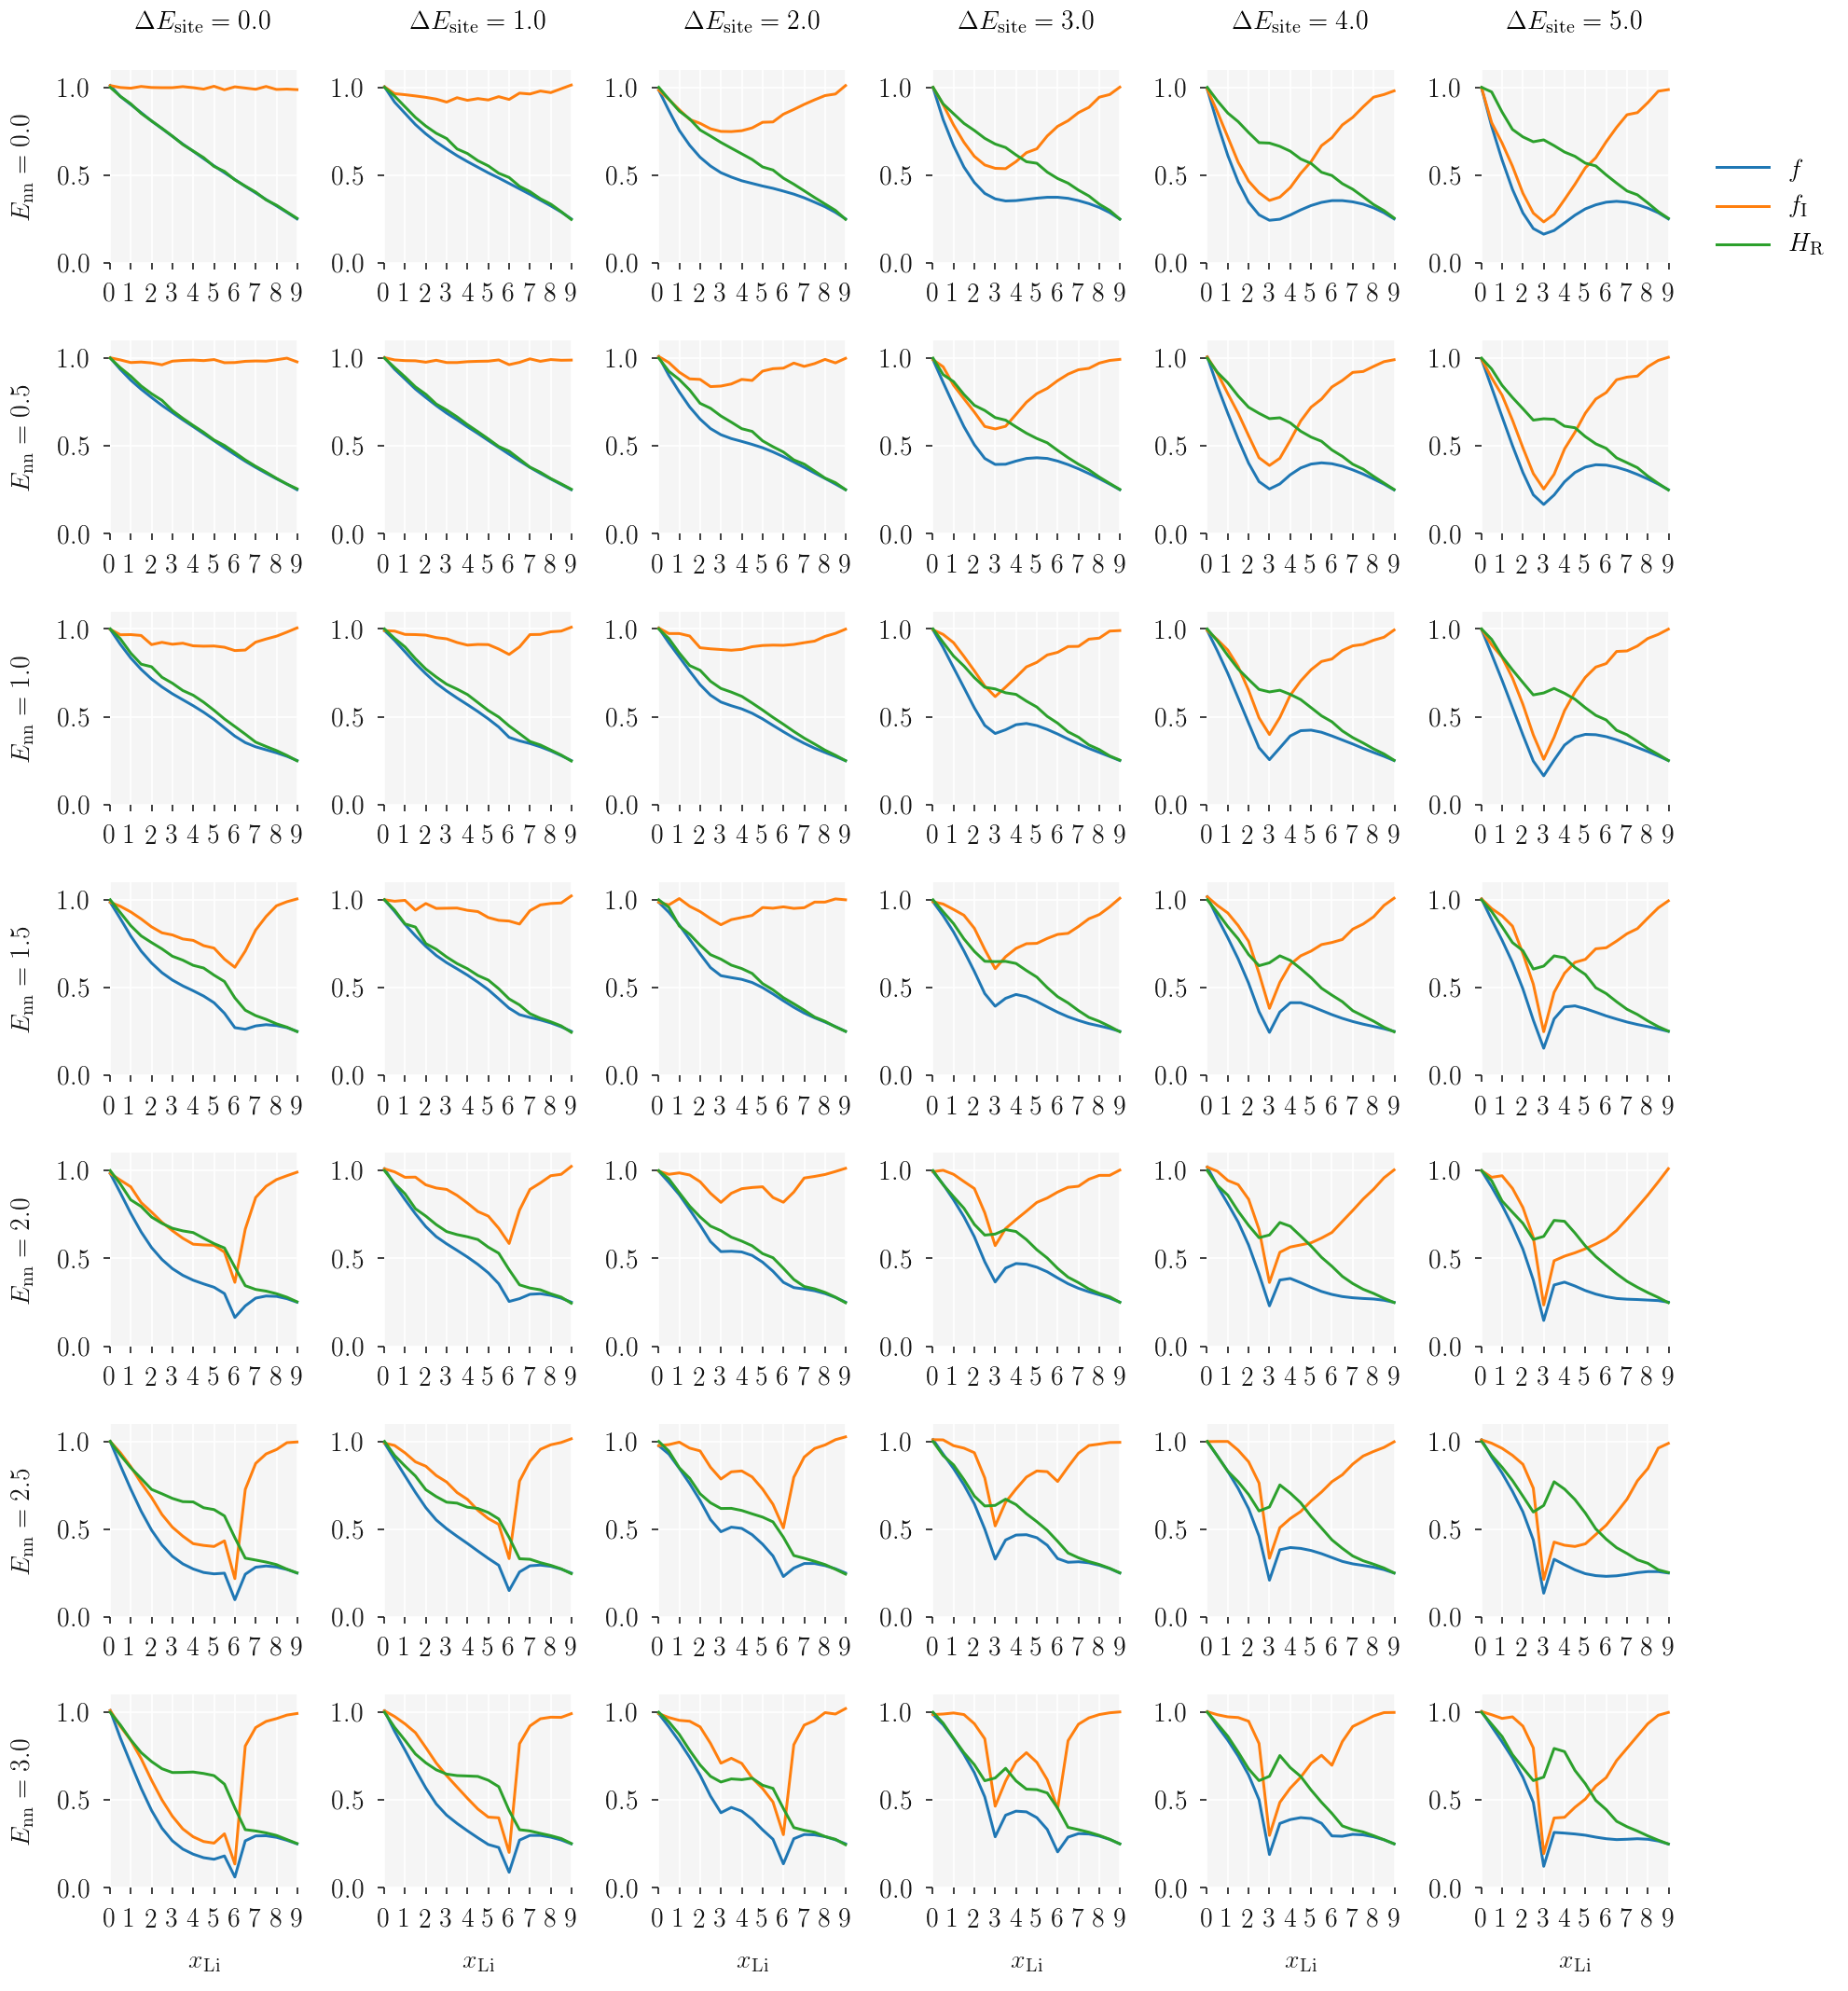

In [15]:
matplotlib.rcParams.update({'font.size': fontsize})
nn_energies = [ 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0 ] 

rcParams['axes.titlepad'] = 10

fig, axes = plt.subplots(nrows=len(nn_energies), ncols=len(site_energies), figsize = (14, 15) )
for i, E_nn in enumerate( nn_energies ):
    for j, E_site in enumerate( site_energies ):
        df = data.loc[ ( data.E_nn == E_nn ) & ( data.E_site == E_site ) ]
        sub_plot( axes[i, j], df, x='n_Li', y=[ 'f', 'f_I', 'H_R' ], x_range=[0, 9.0], y_range=[0.0, 1.1] )
        label_plot( axes, site_energies, nn_energies )
        
# place legend next to the top right subplot  
l = axes[0,5].legend( [r'$f$', r'$f_\mathrm{I}$', r'$H_\mathrm{R}$'], 
                      bbox_to_anchor=(1.2, -0.04), loc='lower left', borderaxespad=0., 
                      edgecolor='#FFFFFF', facecolor='#FFFFFF' )

fig.tight_layout()
fig.savefig(fname='../figures/correlation_miniplots.pdf')

### Tetrahedral and octahedral average site occuaption

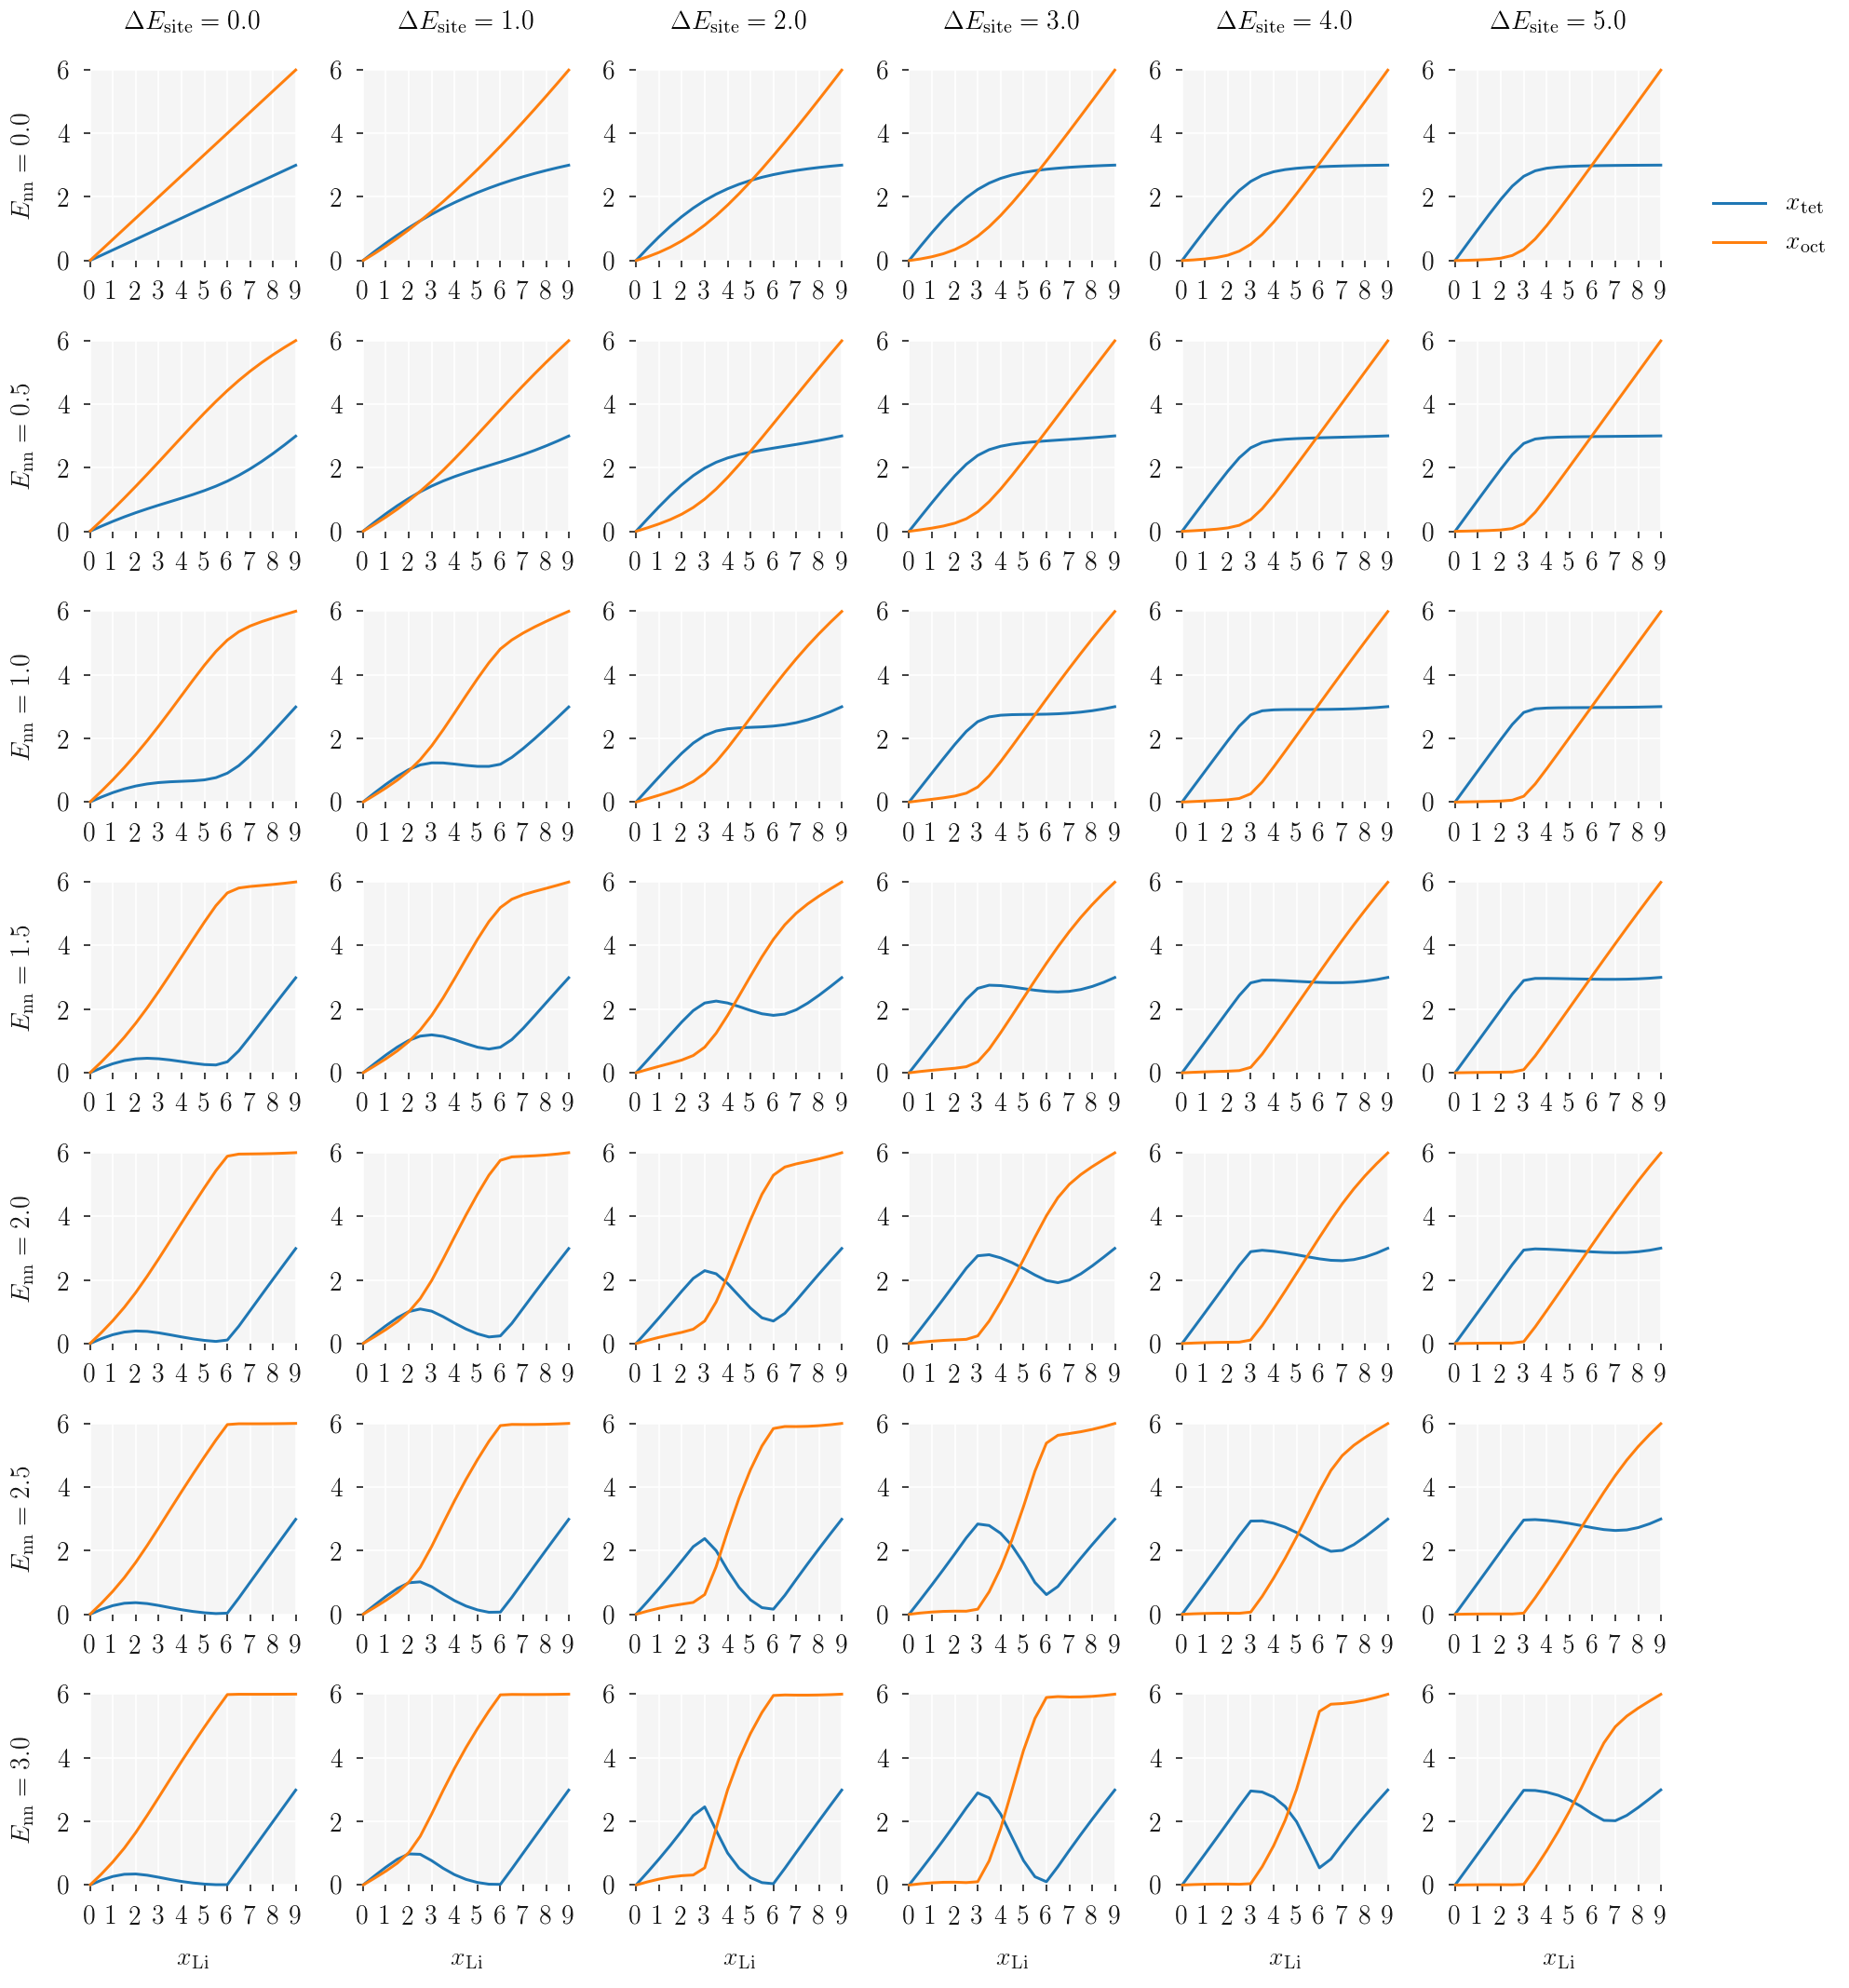

In [16]:
matplotlib.rcParams.update({'font.size': fontsize})
fig, axes = plt.subplots(nrows=len(nn_energies), ncols=len(site_energies), figsize = (14, 15) )
for i, E_nn in enumerate( nn_energies ):
    for j, E_site in enumerate( site_energies ):
        df = data.loc[ ( data.E_nn == E_nn ) & ( data.E_site == E_site ) ]
        sub_plot( axes[i, j], df, x='n_Li', y=['n_tet', 'n_oct'], x_range=[0, 9.0], y_range=[0,6] )
        label_plot( axes, site_energies, nn_energies )

# place legend next to the top right subplot  
l = axes[0,5].legend([r'$x_\mathrm{tet}$', r'$x_\mathrm{oct}$'],
                     bbox_to_anchor=(1.2, -0.04), loc='lower left', borderaxespad=0., 
                     edgecolor='#FFFFFF', facecolor='#FFFFFF')
fig.tight_layout()
fig.savefig(fname='../figures/site_occupation_miniplots.pdf')

### Tracer and &ldquo;jump&rdquo; diffusion coefficients

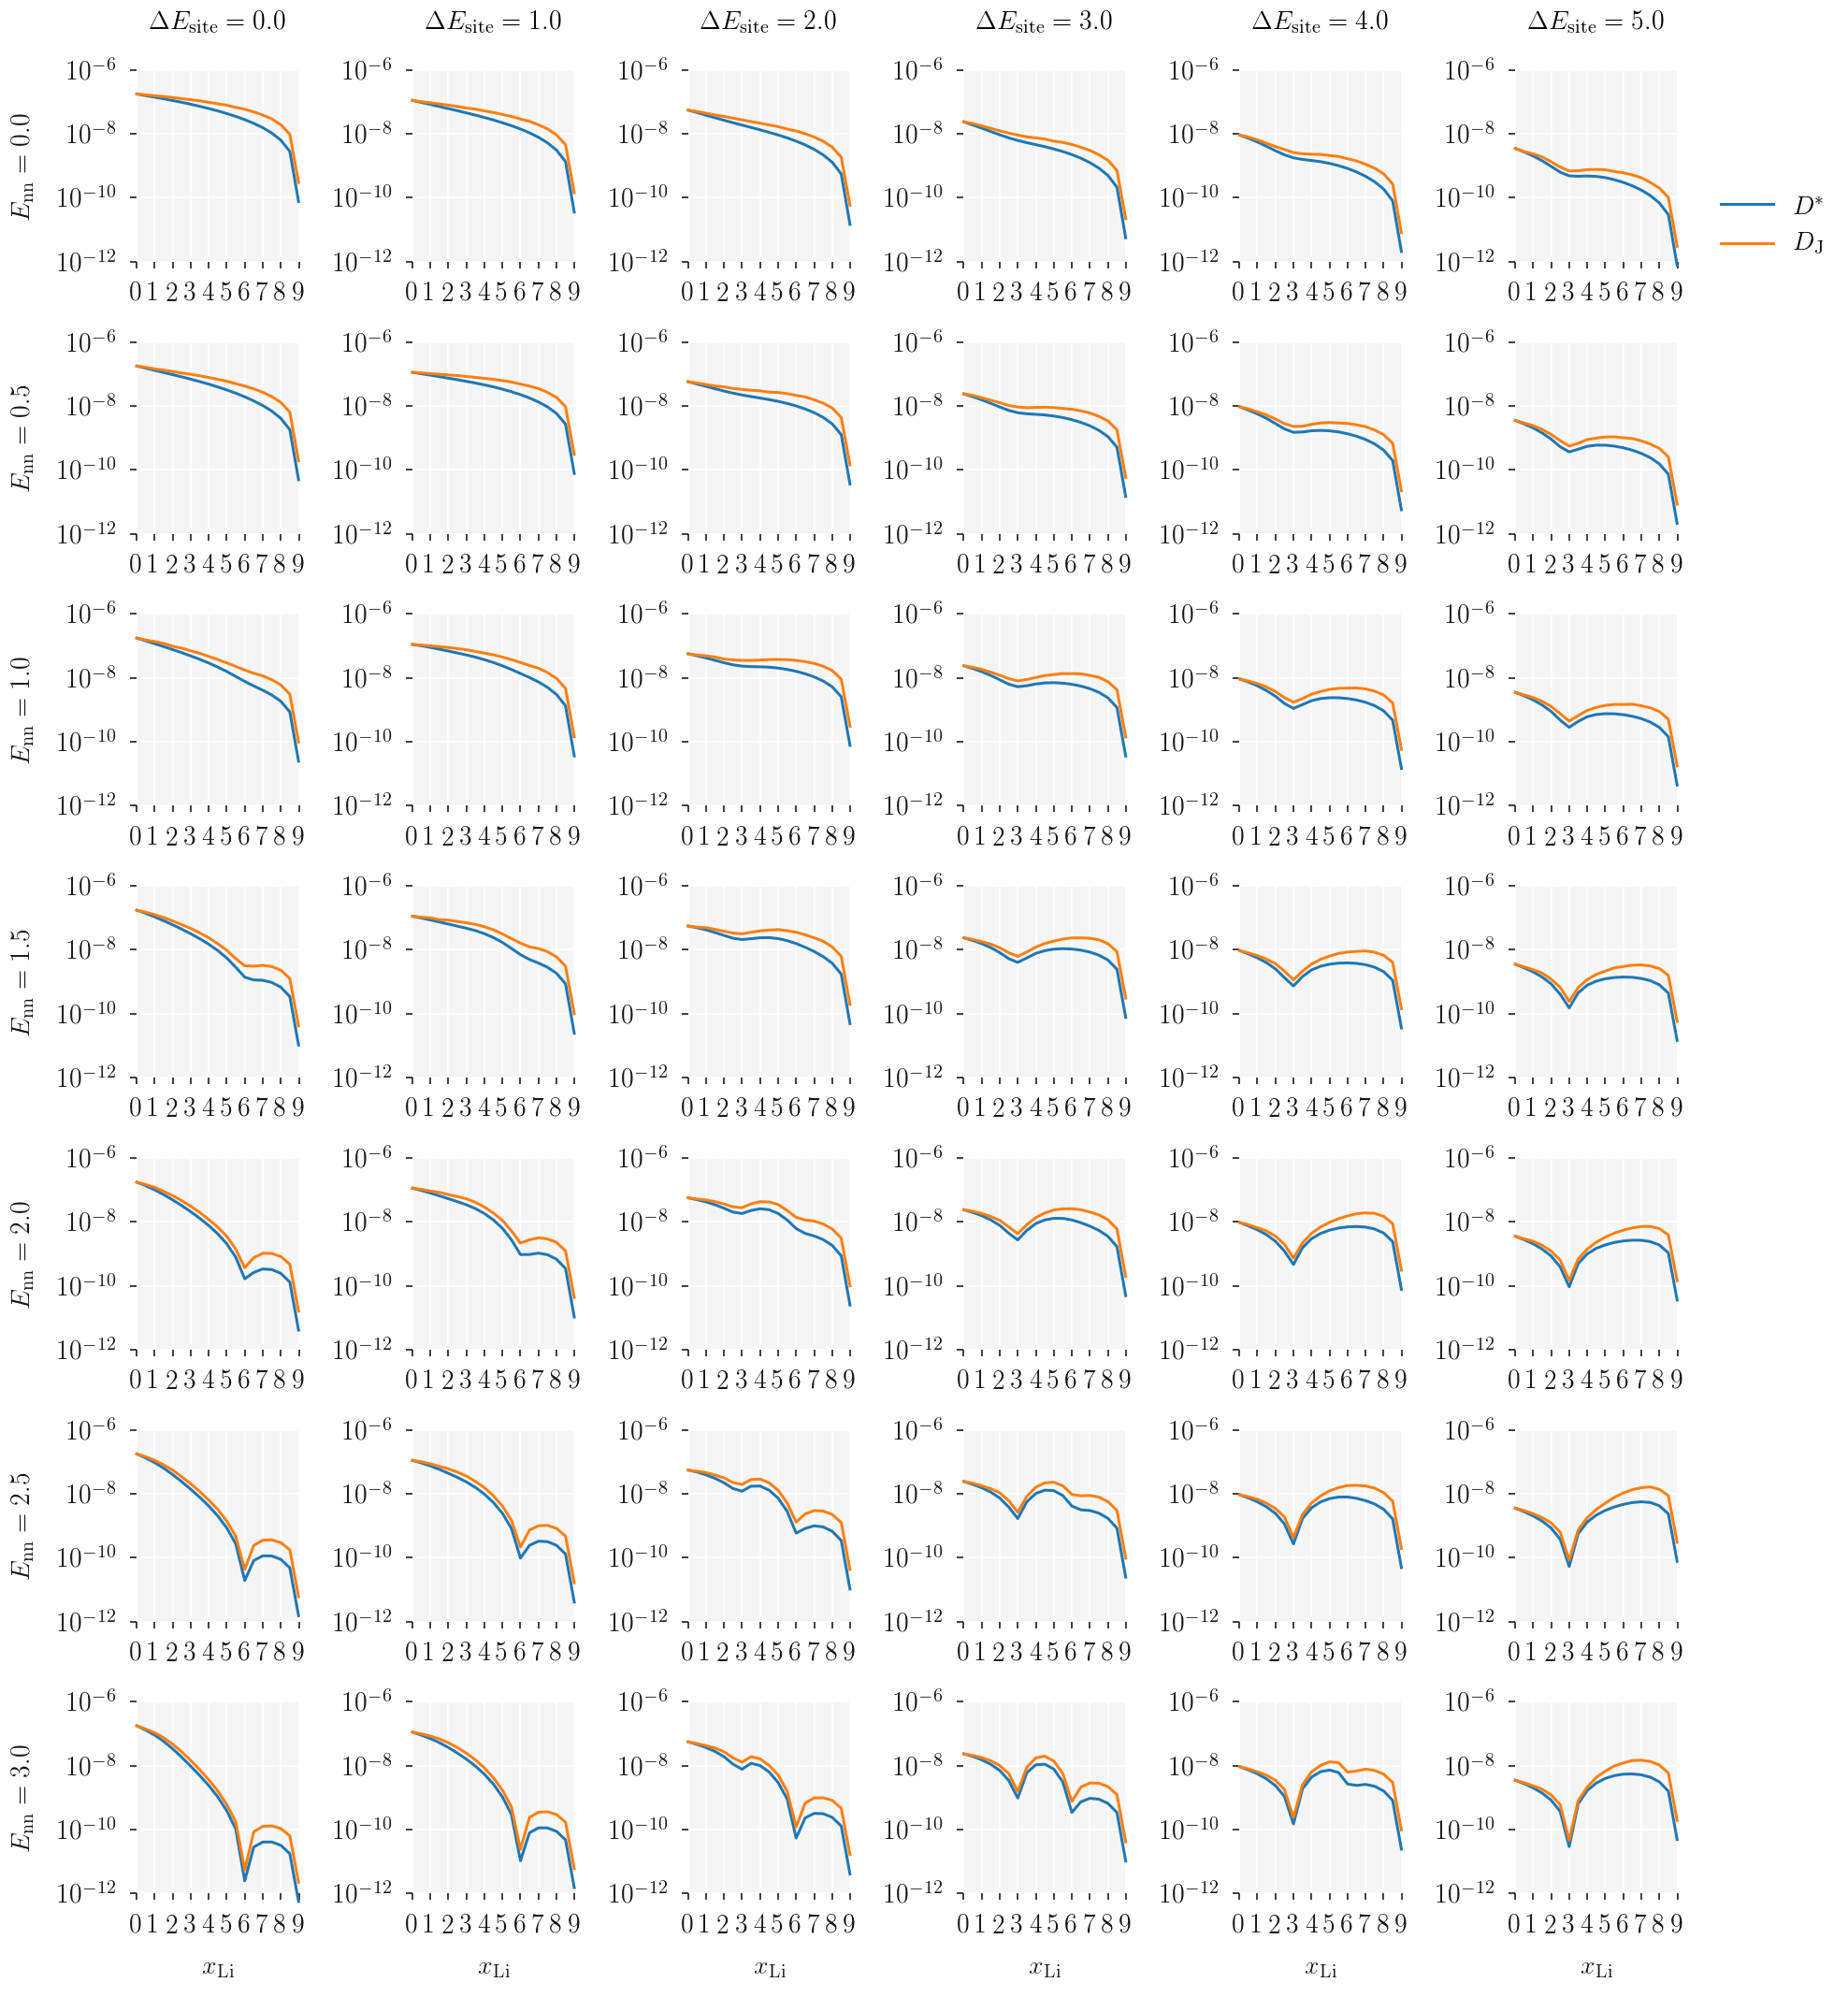

In [17]:
matplotlib.rcParams.update({'font.size': fontsize})
fig, axes = plt.subplots(nrows=len(nn_energies), ncols=len(site_energies), figsize = (14, 15) )
for i, E_nn in enumerate( nn_energies ):
    for j, E_site in enumerate( site_energies ):
        df = data.loc[ ( data.E_nn == E_nn ) & ( data.E_site == E_site ) ]
        sub_plot( axes[i, j], df, x='n_Li', y=['D_t', 'D_coll'], x_range=[0,9], y_range=[1e-12,1e-06], logy=True )
        label_plot( axes, site_energies, nn_energies )

# place legend next to the top right subplot  
l = axes[0,5].legend([r'$D^*$', r'$D_\mathrm{J}$'],
                     bbox_to_anchor=(1.2, -0.04), loc='lower left', borderaxespad=0., 
                     edgecolor='#FFFFFF', facecolor='#FFFFFF')

fig.tight_layout()
fig.savefig(fname='../figures/diffusion_miniplots.pdf')

### Reduced ionic conductivity

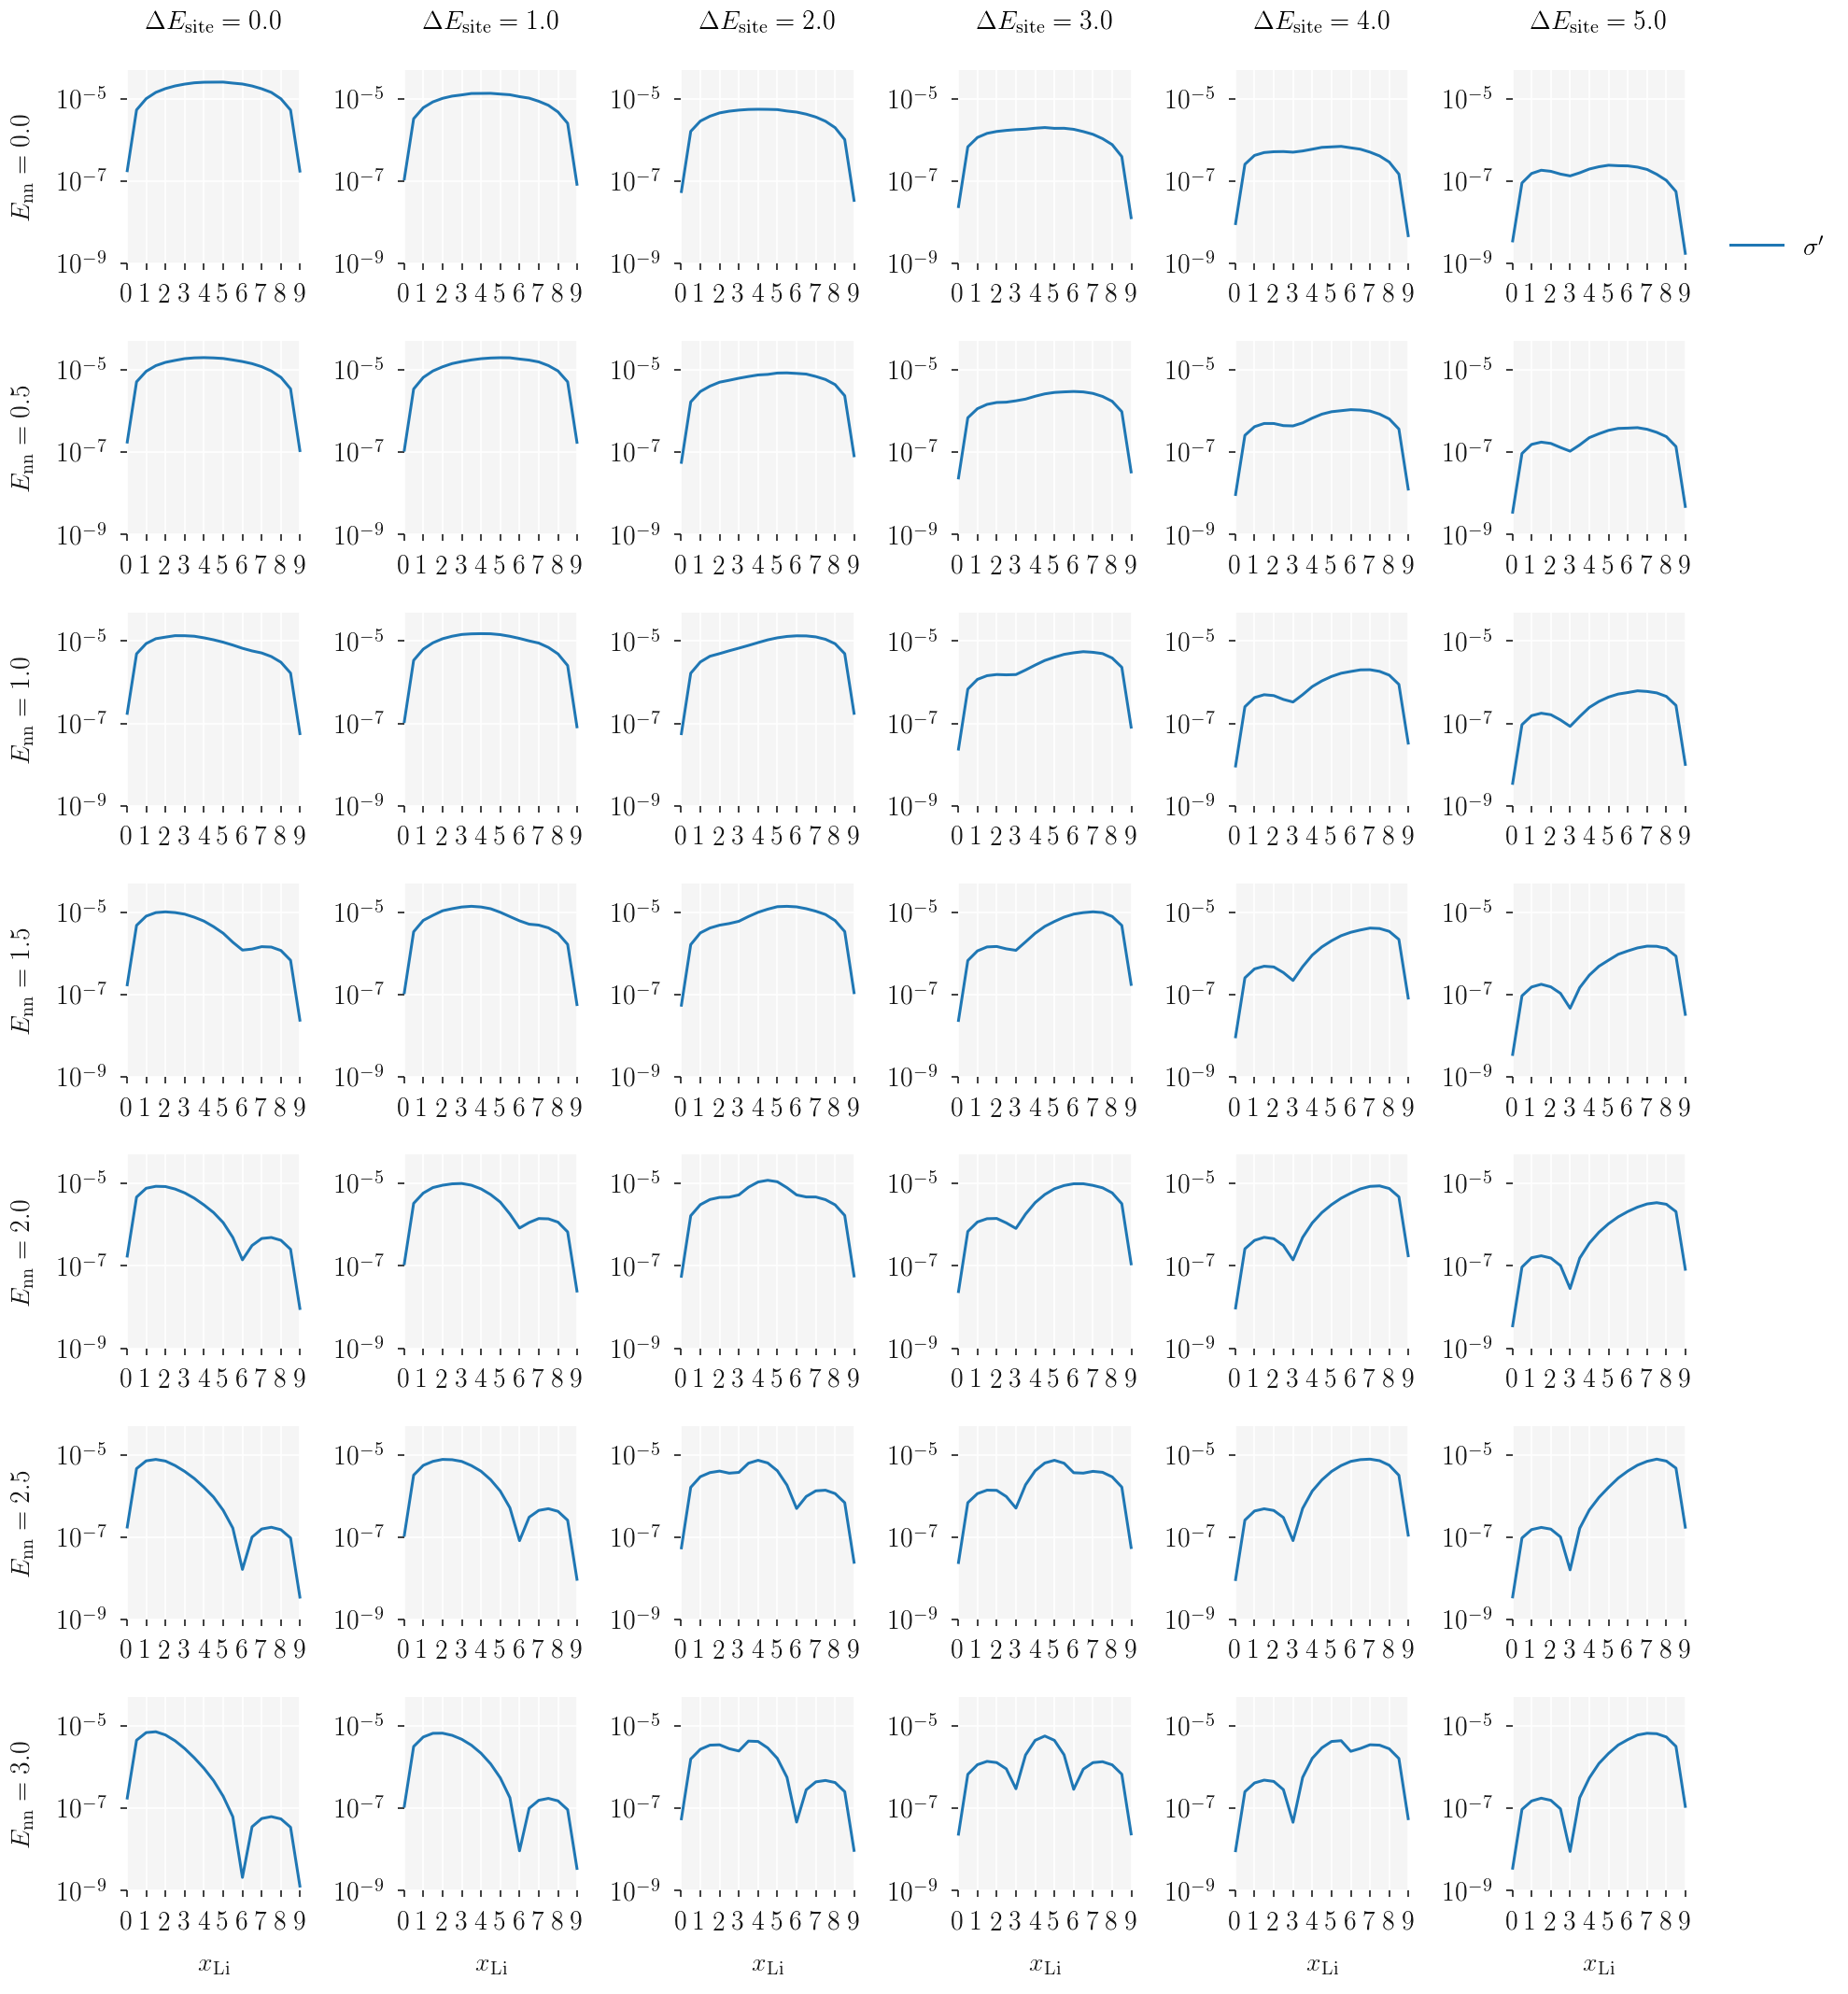

In [18]:
matplotlib.rcParams.update({'font.size': fontsize})

fig, axes = plt.subplots(nrows=len(nn_energies), ncols=len(site_energies), figsize = (14, 15))
for i, E_nn in enumerate( nn_energies ):
    for j, E_site in enumerate( site_energies ):
        df = data.loc[ ( data.E_nn == E_nn ) & ( data.E_site == E_site ) ]
        sub_plot( axes[i, j], df, x='n_Li', y=['sigma_eff'], x_range=[0,9], y_range=[1e-9,5.0e-5], logy=True )
        label_plot( axes, site_energies, nn_energies )

# place legend next to the top right subplot  
l = axes[0,5].legend([r'$\sigma^\prime$'],
                     bbox_to_anchor=(1.2, -0.04), loc='lower left', borderaxespad=0., 
                     edgecolor='#FFFFFF', facecolor='#FFFFFF')

fig.tight_layout()
fig.savefig(fname='../figures/conductivity_miniplots.pdf')

In [19]:
plt.close('all')

## What is the Li stoichiometry that maximises the ionic conductivity?

Using the reduced conductivity data, we can now ask the question: for a particular set of interaction parameters, what is the value of $x(\mathrm{Li})$ that maximises the ionic conductivity?

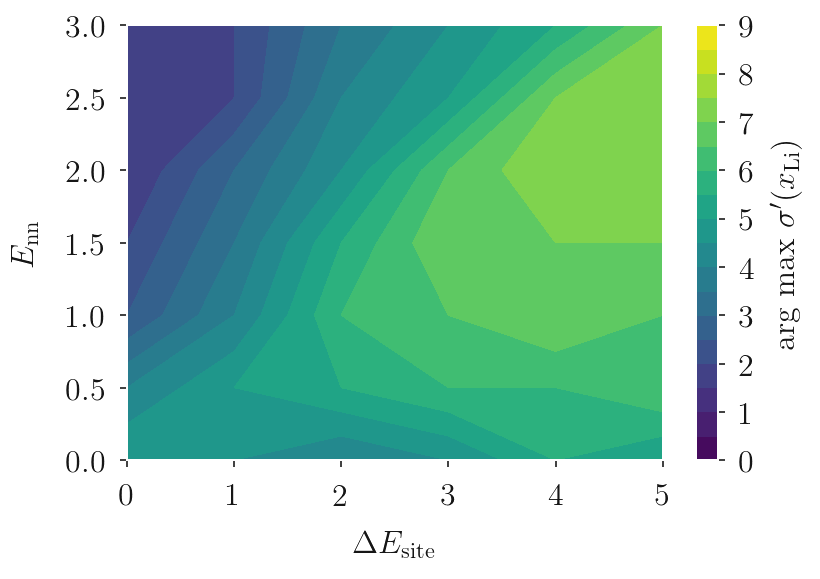

In [20]:
from figure_formatting import fontsize

matplotlib.rcParams.update({'font.size': fontsize})

def func( group ):
    return group[ group.sigma_eff == group.sigma_eff.max() ]

ndata_pd = data.groupby( [ 'E_nn', 'E_site' ] ).apply( func ).reset_index( drop = True )
ndata_pd = ndata_pd.sort_values( by = 'E_nn', ascending = False ).pivot( 'E_nn', 'E_site', 'n_Li' )

ndata = np.nan_to_num( np.array( ndata_pd ) )

fig = plt.figure()
ax = fig.add_subplot(111)

X = np.linspace( 0, 5.0, 6 )
Y = np.linspace( 0, 3.0, 7 )
Z = ndata
levels = np.linspace( 0.0, 9.0, 19 )

x,y=np.meshgrid(X, Y)
ax.set_xlabel( r'$\Delta E_\mathrm{site}$' )
ax.set_ylabel( r'$E_\mathrm{nn}$' )

cs = plt.contourf(x, y, Z, levels=levels, cmap='viridis' )

cbar = plt.colorbar( cs )
cbar.ax.set_ylabel( r'$\arg\,\max\,\sigma^\prime(x_\mathrm{Li})$')
plt.show()

The optimal $x(\mathrm{Li})$ to maximise the ionic conductivity is very sensitive to the relative strength of the two interactions, $E_\mathrm{nn}$ and $\Delta E_\mathrm{site}$. varying from 1.0 to 7.5.

Replot this figure for the manuscript, applying interpolation to smooth the $\left\{E_\mathrm{nn}, \Delta E_\mathrm{site}\right\}$ grid, and adding contour lines.

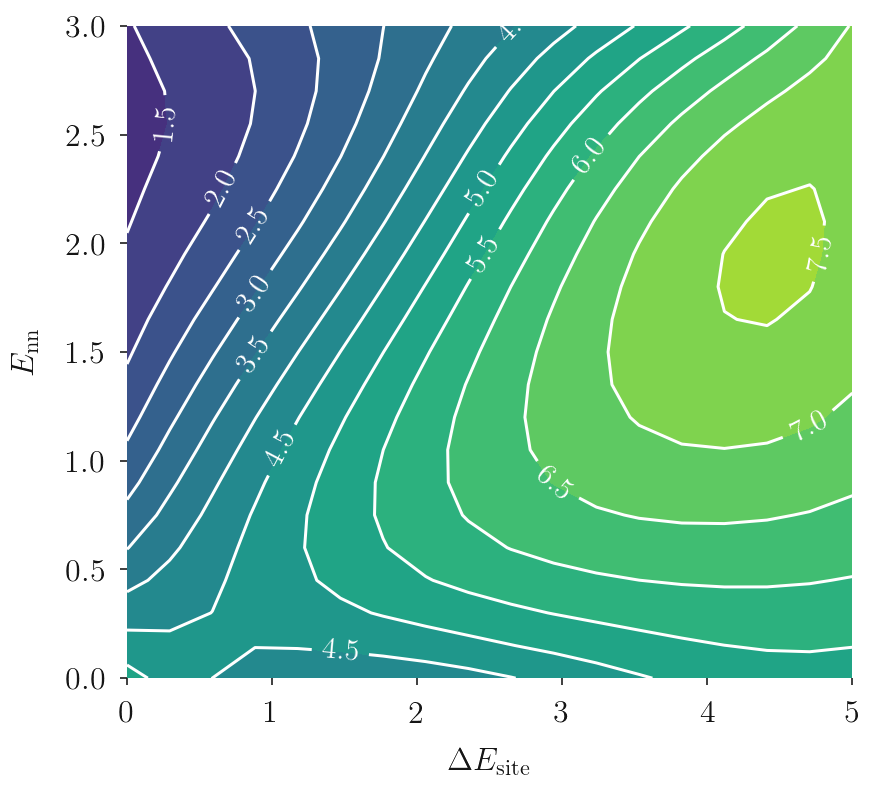

In [21]:
matplotlib.rcParams.update({'font.size': fontsize})

def func( group ):
    return group[ group.sigma_eff == group.sigma_eff.max() ]

ndata_pd = data.groupby( [ 'E_nn', 'E_site' ] ).apply( func ).reset_index( drop = True )
Z = ndata_pd.n_Li.values
Y = ndata_pd.E_nn.values
X = ndata_pd.E_site.values

fig = plt.figure(figsize=(6.5, 6))
ax = fig.add_subplot(111)
for s in [ 'top', 'bottom', 'left', 'right' ]:
    ax.spines[s].set_visible(False)

xnew, ynew = np.mgrid[0:5.0:18j, 0:3.0:21j]
tck = interpolate.bisplrep( X, Y, Z, s=3 )
znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

levels = np.linspace( 0.0, 9.0, 19 )

x,y=np.meshgrid(X, Y)
ax.set_xlabel( r'$\Delta E_\mathrm{site}$' )
ax.set_ylabel( r'$E_\mathrm{nn}$' )

cs = plt.contourf(xnew, ynew, znew, levels=levels, cmap='viridis' )
C = plt.contour(xnew, ynew, znew, 9, colors='white', levels=levels[::])
plt.clabel(C, inline=1, fontsize=15, fmt='%1.1f')

fig.savefig(fname='../figures/max_sigma.pdf')

## Haven ratios as a function of lithium stoichiometry

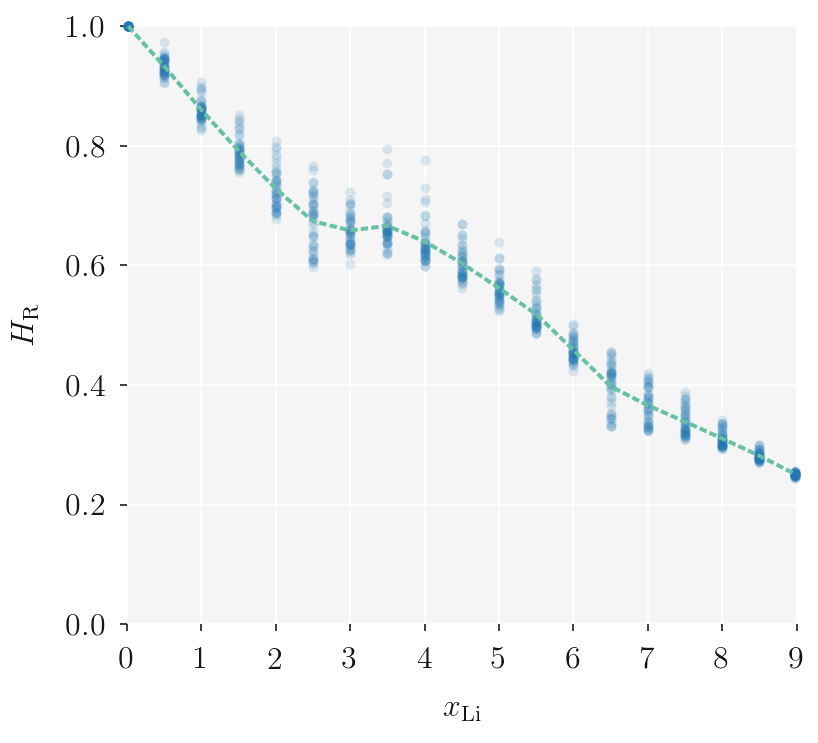

In [22]:
matplotlib.rcParams.update({'font.size': fontsize})

fig, axs = plt.subplots(1,1, figsize=(6,5.5))
for s in [ 'top', 'bottom', 'left', 'right' ]:
    axs.spines[s].set_visible(False)
my_plot( axs, data.n_Li, data.H_R, marker='o', label=r'$H_\mathrm{R}$', alpha=0.15 )
my_plot( axs, data.groupby('n_Li').n_Li.mean(), data.groupby('n_Li').H_R.mean(), marker='--', color='#66c2a5', linewidth=2 )
setup_axes( axs, [0.0, 1.0] )
axs.set_ylabel(r"$H_\mathrm{R}$")
fig.savefig(fname='../figures/haven_ratios.pdf')

## Correlation effects on Arrhenius plots

The correlation factors, $f$, and $f_\mathrm{I}$, rescale the diffusion coefficient and ionic conductivity from their &ldquo;random walk&rdquo; values. In this work we have considered interaction strengths in reduced units; they have been rescaled by a factor of $kT$. For a given absolute interaction strength, the _reduced_ interaction strength therefore varies with temperature. As a consequence, the correlation factors are also temperature dependent. This introduces an additional temperature dependence into the tracer diffusion coefficient and ionic conductivity.

To illustrate this, we can consider the nearest-neighbour interaction for a pair of lithium ions separated by one tetrahedral–octahedral spacing (2.4 Å in LLZO), using the relative permittivity of $\epsilon_\mathrm{r}\approx50$ of Rettenwander _et al._ [1] (although it is questionable whether the bulk dielectric response is appropriate at this small separation).

[1] Rettenwander _et al._ _Inorg. Chem._ **54** *10440* (2015).

In [23]:
from scipy.constants import physical_constants
k_B = physical_constants['Boltzmann constant in eV/K'][0]
Hartree_to_eV = physical_constants['Hartree energy in eV'][0]
Angstrom_to_bohr = 1/(physical_constants['Bohr radius'][0]*1e10)

In [24]:
def coulomb_energy_in_eV( q_1, q_2, r, epsilon=1.0 ):
    """
    Calculate the Coulomb energy between two point charges in eV
    
    Args:
        q_1 (float): charge 1 (atomic units).
        q_2 (float): charge 2 (atomic units).
        r   (float): distance between the point charges (Angstroms).
        epsilon (float): relative permittivity. Default = 1.0.
        
    Returns:
        (float): The Coulombic interaction energy in eV.
    """
    return q_1 * q_2 / ( epsilon * r * Angstrom_to_bohr ) * Hartree_to_eV    

In [25]:
ref_temp = 298.0
nearest_neighbour_repulsion = coulomb_energy_in_eV( 1.0, 1.0, 2.4, epsilon=50.0 ) / ( ref_temp * k_B )
nearest_neighbour_repulsion

4.672846836606651

At 298 K, even with this large relative permittivity, the interaction energy between two lithium ions separated by 2.4 Å is $\sim 4.7 \times kT$.

The ionic conductivity can be calculated from

\begin{equation}
\sigma = \frac{Cq^2}{kT}\frac{1}{6}a^2\widetilde{\nu}_0\,f_\mathrm{I},
\end{equation}

where

\begin{equation}
\widetilde{\nu}=\widetilde{\nu}_0\mathrm{exp}\left(-\frac{\Delta E_\mathrm{act}}{kT}\right).
\end{equation}

Combining these equations, $\sigma T$ can be calculated as

\begin{equation}
\sigma T = A \mathrm{exp}\left(-\frac{\Delta E_\mathrm{act}}{kT}\right)\,f_\mathrm{I},
\end{equation}

where

\begin{equation}
A=\frac{Cq^2}{k}\frac{1}{6}a^2\widetilde{\nu}_0.
\end{equation}

To show the effect of a temperature dependence correlation factor on an Arrhenius plot of $\sigma T$, we set $A=1$, and plot

\begin{equation}
\ln\left(\sigma T\right)=\ln A + \ln f_\mathrm{I} - \frac{\Delta E_\mathrm{act}}{kT}.
\end{equation}


In [26]:
def sigmaT( prefactor, activation_energy, temperature, f ):
    """
    Calculate \sigma T = A exp( -E_act / kT ) f
    
    Args:
        prefactor (float): The prefactor A.
        activation_energy (float): The activation energy E_act.
        temperature (float):       The temperature in Kelvin.
        f (float):                 The correlation factor (typically also a function of temperature).
        
    Returns:
        (float): sigma × T
    """
    return prefactor * np.exp( -activation_energy / ( k_B * temperature ) ) * f

In [27]:
# Select data for n_Li=6, E_site = 0.0

sub_data = data[ ( data.n_Li == 6.0 ) & ( data.E_site == 0 ) ]

In [28]:
# interpolate f_I as a function of E_nn

from scipy.interpolate import interp1d
f_interpolated = interp1d( sub_data.E_nn, sub_data.f_I, kind='cubic')

Plot relative ionic conductivities as Arrhenius plots for $f=1$ and $f=f_\mathrm{I}(T)$ (setting the prefactor $A=1$ for conveience).

In [29]:
e_int = nearest_neighbour_repulsion
e_act = 0.3 # eV
a = 1.0
temp = np.linspace( 600.0, 2000.0 )
e_int_reduced = e_int * ref_temp / temp
f = f_interpolated( e_int * ref_temp / temp )
inverse_temp = 1/temp
ideal_conductivity = np.log( sigmaT( a, e_act, temp, f=1.0 ))
actual_conductivity = np.log( sigmaT( a, e_act, temp, f=f ) )

For both data sets, what activation energies would we measure by assuming a temperature independent collective correlation factor? i.e. assuming the low temperature slope gives $\Delta E_\mathrm{act}/k_\mathrm{B}$.

In [30]:
from scipy.stats import linregress
ideal_slope, ideal_intercept = linregress( inverse_temp[:10], ideal_conductivity[:10] )[0:2]
E_act_observed_ideal = -ideal_slope * k_B
print( "Fitted activation energy for \"ideal\" data:", E_act_observed_ideal )
actual_low_temp_slope, actual_intercept = linregress( inverse_temp[:25], actual_conductivity[:25] )[0:2]
E_act_observed_actual = -actual_low_temp_slope * k_B
print( "Fitted activation energy for \"real\" data:", E_act_observed_actual )

Fitted activation energy for "ideal" data: 0.2999999999999998
Fitted activation energy for "real" data: 0.41561432556545175


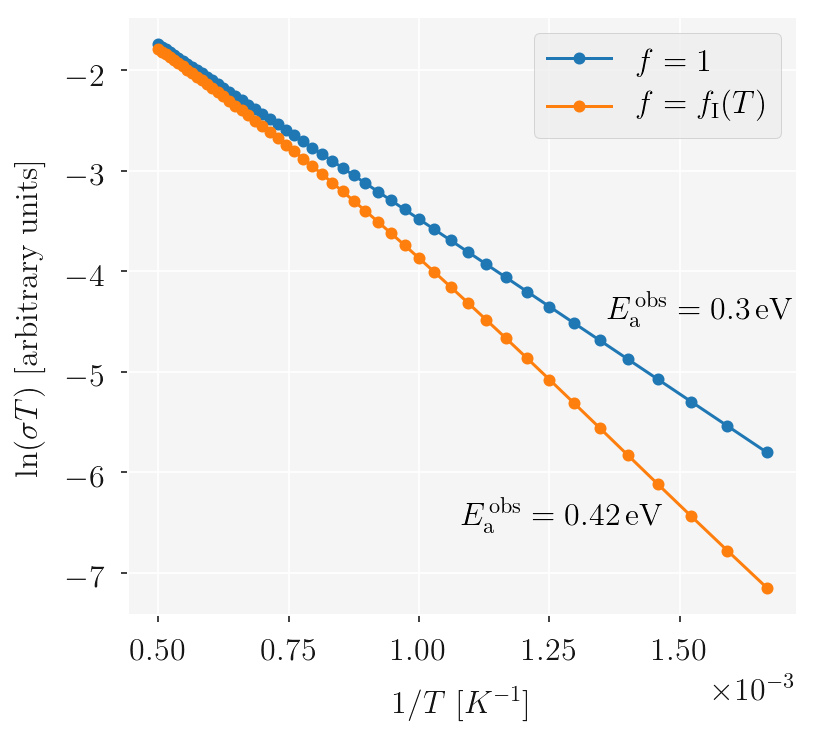

In [31]:
matplotlib.rcParams.update({'font.size': fontsize})

fig, axs = plt.subplots(1,1, figsize=(6,5.5))
axs.plot( inverse_temp, ideal_conductivity, 'o-', label=r"$f=1$" )
axs.plot( inverse_temp, actual_conductivity, 'o-', label=r"$f=f_\mathrm{I}(T)$" )
axs.set_xlabel(r"$1/T$ [$K^{-1}$]")
axs.set_ylabel(r"$\ln(\sigma T)$ [arbitrary units]")
axs.legend()
axs.text(1/735,-4.55,r"$E_\mathrm{{a}}^\mathrm{{\,obs}}={}\,\mathrm{{eV}}$".format(E_act_observed_ideal.round(1)) )
axs.text(1/925,-6.6,r"$E_\mathrm{{a}}^\mathrm{{\,obs}}={}\,\mathrm{{eV}}$".format(E_act_observed_actual.round(2)) )
fig.savefig(fname='../figures/arrhenius_example.pdf')

In [32]:
plt.close('all')

In [33]:
%load_ext version_information
%version_information pandas, numpy, scipy, matplotlib, version_information

Software versions
Python 3.6.1 64bit [GCC 4.2.1 Compatible Apple LLVM 8.1.0 (clang-802.0.42)]
IPython 6.3.1
OS Darwin 17.5.0 x86_64 i386 64bit
pandas 0.22.0
numpy 1.14.2
scipy 1.0.1
matplotlib 2.2.2
version_information 1.0.3
Sun Apr 15 16:06:04 2018 BST